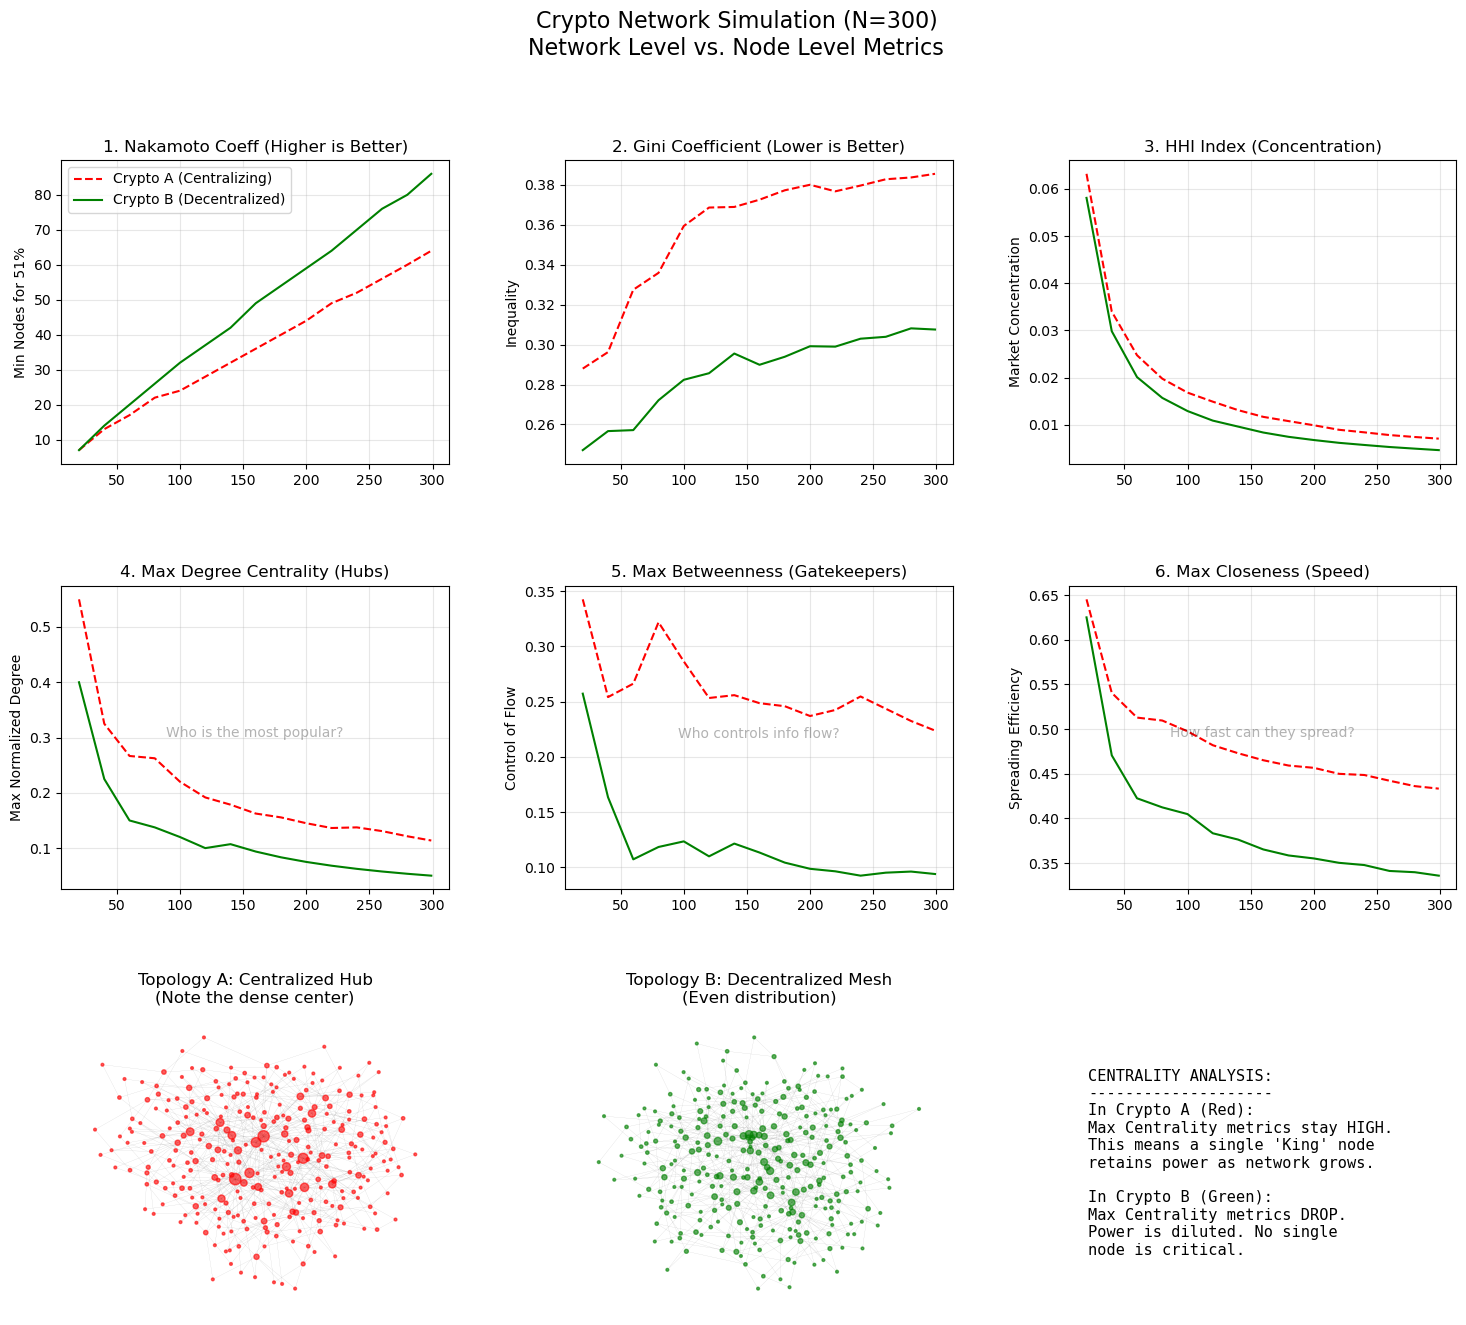

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# ==========================================
# 1. 定义检测指标 (Metrics) - 新增中心性计算
# ==========================================
def calculate_metrics(G):
    # --- 基础数据 ---
    degrees = np.array([d for n, d in G.degree()])
    if len(degrees) == 0: return 0, 0, 0, 0, 0, 0
    
    n = len(degrees)
    total_deg = np.sum(degrees)
    
    # --- A. 宏观指标 (Network Level) ---
    
    # 1. Nakamoto Coefficient
    sorted_deg = np.sort(degrees)[::-1]
    current_sum = 0
    nakamoto = 0
    for d in sorted_deg:
        current_sum += d
        nakamoto += 1
        if current_sum > total_deg * 0.51:
            break
            
    # 2. Gini Coefficient
    sorted_asc = np.sort(degrees)
    cum_deg = np.cumsum(sorted_asc)
    if cum_deg[-1] == 0: 
        gini = 0
    else:
        gini = (n + 1 - 2 * np.sum(cum_deg) / cum_deg[-1]) / n
        
    # 3. HHI (Market Concentration)
    shares = degrees / total_deg if total_deg > 0 else degrees
    hhi = np.sum(shares ** 2)

    # --- B. 微观指标 (Node Centrality Level) ---
    # 我们关注网络中最强个体的数值 (Max Value)，看是否出现了寡头

    # 4. Degree Centrality (Max): Most Popular Hub
    deg_cent = nx.degree_centrality(G)
    max_deg_c = max(deg_cent.values()) if deg_cent else 0

    # 5. Betweenness Centrality (Max): Strongest Gatekeeper
    # 注意: 计算量大，500个节点还能接受，如果节点数>1000建议加 k=参数近似计算
    bet_cent = nx.betweenness_centrality(G) 
    max_bet_c = max(bet_cent.values()) if bet_cent else 0

    # 6. Closeness Centrality (Max): Fastest Spreader
    clo_cent = nx.closeness_centrality(G)
    max_clo_c = max(clo_cent.values()) if clo_cent else 0
    
    return nakamoto, gini, hhi, max_deg_c, max_bet_c, max_clo_c

# ==========================================
# 2. 模拟成长过程
# ==========================================

final_size = 300  # 建议设为 300 或 500 (计算介数中心性比较耗时)
m_edges = 2       

G_centralized = nx.complete_graph(5)   # Scenario A
G_decentralized = nx.complete_graph(5) # Scenario B

# 扩展历史记录字典
history = {
    'time': [],
    # Network Level
    'A_nakamoto': [], 'A_gini': [], 'A_hhi': [],
    'B_nakamoto': [], 'B_gini': [], 'B_hhi': [],
    # Individual Centrality Level (Max values)
    'A_deg_c': [], 'A_bet_c': [], 'A_clo_c': [],
    'B_deg_c': [], 'B_bet_c': [], 'B_clo_c': []
}

# print(f"开始模拟 (目标节点: {final_size})...这可能需要几秒钟...")
start_time = time.time()

for t in range(5, final_size):
    # --- Scenario A: Preferential Attachment ---
    degrees_A = [d for n, d in G_centralized.degree()]
    probs_A = np.array(degrees_A) / sum(degrees_A)
    targets_A = np.random.choice(G_centralized.nodes(), size=m_edges, p=probs_A, replace=False)
    
    new_node_A = max(G_centralized.nodes()) + 1
    G_centralized.add_node(new_node_A)
    for target in targets_A:
        G_centralized.add_edge(new_node_A, target)

    # --- Scenario B: Random Attachment ---
    existing_nodes_B = list(G_decentralized.nodes())
    targets_B = random.sample(existing_nodes_B, m_edges)
    
    new_node_B = max(G_decentralized.nodes()) + 1
    G_decentralized.add_node(new_node_B)
    for target in targets_B:
        G_decentralized.add_edge(new_node_B, target)
        
    # --- 记录指标 (每20步记录一次以加快速度) ---
    if t % 20 == 0 or t == final_size - 1:
        # print(f"正在计算 Step {t} 的指标...") # 可选：显示进度
        
        # 计算 A
        nk_A, gini_A, hhi_A, dc_A, bc_A, cc_A = calculate_metrics(G_centralized)
        # 计算 B
        nk_B, gini_B, hhi_B, dc_B, bc_B, cc_B = calculate_metrics(G_decentralized)
        
        history['time'].append(t)
        # Store A
        history['A_nakamoto'].append(nk_A); history['A_gini'].append(gini_A); history['A_hhi'].append(hhi_A)
        history['A_deg_c'].append(dc_A); history['A_bet_c'].append(bc_A); history['A_clo_c'].append(cc_A)
        # Store B
        history['B_nakamoto'].append(nk_B); history['B_gini'].append(gini_B); history['B_hhi'].append(hhi_B)
        history['B_deg_c'].append(dc_B); history['B_bet_c'].append(bc_B); history['B_clo_c'].append(cc_B)

# print(f"模拟完成! 耗时: {time.time()-start_time:.2f}s")

# ==========================================
# 3. 可视化对比 (3x3 Grid) - 透明背景输出
# ==========================================

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# --- Row 1: Network Level Metrics (宏观) ---

# 1. Nakamoto
axes[0,0].plot(history['time'], history['A_nakamoto'], 'r--', label='Crypto A (Centralizing)')
axes[0,0].plot(history['time'], history['B_nakamoto'], 'g-', label='Crypto B (Decentralized)')
axes[0,0].set_title("1. Nakamoto Coeff (Higher is Better)")
axes[0,0].set_ylabel("Min Nodes for 51%")
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. Gini
axes[0,1].plot(history['time'], history['A_gini'], 'r--', label='Crypto A')
axes[0,1].plot(history['time'], history['B_gini'], 'g-', label='Crypto B')
axes[0,1].set_title("2. Gini Coefficient (Lower is Better)")
axes[0,1].set_ylabel("Inequality")
axes[0,1].grid(True, alpha=0.3)

# 3. HHI
axes[0,2].plot(history['time'], history['A_hhi'], 'r--', label='Crypto A')
axes[0,2].plot(history['time'], history['B_hhi'], 'g-', label='Crypto B')
axes[0,2].set_title("3. HHI Index (Concentration)")
axes[0,2].set_ylabel("Market Concentration")
axes[0,2].grid(True, alpha=0.3)

# --- Row 2: Node Centrality Level (微观 - Max Value) ---

# 4. Max Degree Centrality
axes[1,0].plot(history['time'], history['A_deg_c'], 'r--', label='Crypto A')
axes[1,0].plot(history['time'], history['B_deg_c'], 'g-', label='Crypto B')
axes[1,0].set_title("4. Max Degree Centrality (Hubs)")
axes[1,0].set_ylabel("Max Normalized Degree")
axes[1,0].text(0.5, 0.5, "Who is the most popular?", transform=axes[1,0].transAxes, 
               ha='center', alpha=0.3, fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# 5. Max Betweenness Centrality
axes[1,1].plot(history['time'], history['A_bet_c'], 'r--', label='Crypto A')
axes[1,1].plot(history['time'], history['B_bet_c'], 'g-', label='Crypto B')
axes[1,1].set_title("5. Max Betweenness (Gatekeepers)")
axes[1,1].set_ylabel("Control of Flow")
axes[1,1].text(0.5, 0.5, "Who controls info flow?", transform=axes[1,1].transAxes, 
               ha='center', alpha=0.3, fontsize=10)
axes[1,1].grid(True, alpha=0.3)

# 6. Max Closeness Centrality
axes[1,2].plot(history['time'], history['A_clo_c'], 'r--', label='Crypto A')
axes[1,2].plot(history['time'], history['B_clo_c'], 'g-', label='Crypto B')
axes[1,2].set_title("6. Max Closeness (Speed)")
axes[1,2].set_ylabel("Spreading Efficiency")
axes[1,2].text(0.5, 0.5, "How fast can they spread?", transform=axes[1,2].transAxes, 
               ha='center', alpha=0.3, fontsize=10)
axes[1,2].grid(True, alpha=0.3)


# --- Row 3: Topology & Summary ---

# 7. Topology A
pos_A = nx.spring_layout(G_centralized, seed=42)
d_A = [d for n, d in G_centralized.degree()]
axes[2,0].set_title(f"Topology A: Centralized Hub\n(Note the dense center)")
nx.draw(G_centralized, pos_A, ax=axes[2,0], node_size=[v*2 for v in d_A], 
        node_color='red', alpha=0.6, edge_color='gray', width=0.1)

# 8. Topology B
pos_B = nx.spring_layout(G_decentralized, seed=42)
d_B = [d for n, d in G_decentralized.degree()]
axes[2,1].set_title(f"Topology B: Decentralized Mesh\n(Even distribution)")
nx.draw(G_decentralized, pos_B, ax=axes[2,1], node_size=[v*2 for v in d_B], 
        node_color='green', alpha=0.6, edge_color='gray', width=0.1)

# 9. Text Summary
axes[2,2].axis('off')
summary_text = (
    "CENTRALITY ANALYSIS:\n"
    "--------------------\n"
    "In Crypto A (Red):\n"
    "Max Centrality metrics stay HIGH.\n"
    "This means a single 'King' node\n"
    "retains power as network grows.\n\n"
    "In Crypto B (Green):\n"
    "Max Centrality metrics DROP.\n"
    "Power is diluted. No single\n"
    "node is critical."
)
axes[2,2].text(0.05, 0.5, summary_text, fontsize=11, family='monospace', va='center')

plt.suptitle(f"Crypto Network Simulation (N={final_size})\nNetwork Level vs. Node Level Metrics", fontsize=16)

# 保存时设置 transparent=True
plt.savefig('crypto_simulation_centrality_transparent.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()